# This code implements the example that compares Variagroms for the data.

In [3]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import pickle
import scipy.stats as stats
from sklearn.covariance import ledoit_wolf
from scipy.linalg import (
    expm, logm, sqrtm, fractional_matrix_power)

import seaborn as sns
import matplotlib
from mpl_toolkits.basemap import Basemap

sns.set()
sns.set_context("talk", font_scale = 1)
sns.set_style('whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
# matplotlib.rcParams['axes.axisbelow'] = True
#matplotlib.rcParams.update({'figure.autolayout': True})
# matplotlib.rcParams['figure.figsize'] = [10, 7]
# %matplotlib inline

In [4]:
df = pd.read_csv(r"C:\Users\17345\workingpapers\Atmospheric_Riemannian\AtmosphericData\AtmosphericData\data\Hourly_data_of_Beijing_from_Jinxi_20210305.csv", delimiter = ',')
latlon = pd.read_csv(r"C:\Users\17345\workingpapers\Atmospheric_Riemannian\AtmosphericData\AtmosphericData\data\latlondata.csv",delimiter = ',')

In [5]:
df = df.interpolate(method='linear', axis=0)
df1 = df.iloc[:, 11:17]

In [6]:
df1

,CO,NO2,O3,PM10,PM2.5,SO2
0,1.1,76.0,3.0,91.0,54.0,21.0
1,1.0,75.0,3.0,80.0,50.0,14.0
2,0.9,73.0,2.0,72.0,44.0,12.0
3,0.8,72.0,2.0,81.0,47.0,10.0
4,0.8,73.0,2.0,75.0,36.0,9.0
...,...,...,...,...,...,...
297835,0.7,67.0,6.0,75.0,38.0,7.0
297836,0.7,64.0,8.0,77.0,43.0,7.0
297837,0.7,59.0,10.0,74.0,43.0,7.0
297838,0.7,55.0,14.0,73.0,43.0,8.0


In [7]:
#Indices for unique values

Sites = df.Site.unique()
Dates = df.Date.unique()
Months = df.Month.unique()
holi = df.Holiday.unique()
hours = df.Hour.unique()
dow = df.DOW.unique()

In [8]:
#Compute Covariance Matrices

#Remove extreme outlier site
Sites = Sites[np.where(Sites != 'TT')[0]]

Matrices = []
labels = []
Covs = []
coord = []
numz = []
Cors = []
for i in tqdm(Sites):
    for j in [holi[2]]:
        Data = df1.loc[(df['Site'] == i) & (df['Hour'] >= 10) & (df['Hour'] <= 15) & (df['Holiday'] == j) & (df['Month'] >= 0) & (df['Month'] <= 12)]
        label = df.loc[(df['Site'] == i) & (df['Hour'] >= 10) & (df['Hour'] <= 15) & (df['Holiday'] == j) & (df['Month'] >= 0) & (df['Month'] <= 12)].iloc[:,0]
        lon = latlon.loc[latlon['Site'] == i].iloc[:,1]
        lat = latlon.loc[latlon['Site'] == i].iloc[:,2]
        coord.append(np.hstack([lat,lon]))
        Matrices.append(Data.values)
        labels.append(j)
        Wcov = ledoit_wolf(Data.values)[0]
#         Wcov = np.cov(Data.values.T)
        Covs.append(Wcov)
        Cors.append(np.corrcoef(Data.values)[0])

  0%|          | 0/33 [00:00<?, ?it/s]

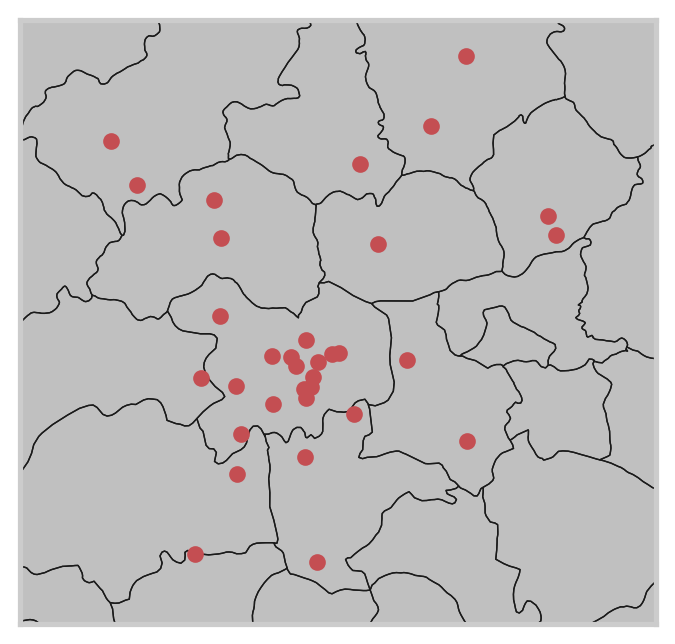

In [9]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(dpi = 200)
m= Basemap(llcrnrlon=115.5, llcrnrlat=39.5, urcrnrlon=117.5, urcrnrlat=40.5, projection='lcc', lat_1=33, lat_2=45, lon_0=100) 
m.readshapefile(r'gadm36_CHN_3', 'counties', drawbounds = True)
m.drawcountries(color='#ffffff', linewidth=0.5)
m.fillcontinents(color='#c0c0c0', lake_color='#ffffff')

i = 0

for a,b in coord:
    
    x, y = m(b,a)
    plt.plot(x, y, 'or', markersize=5)
#     plt.text(x, y, Sites[i], fontsize=5);
    
    i+=1

plt.savefig("Beijing_map.svg")

In [10]:
#linear Distance

def linear(C1,C2):
    dist = np.linalg.norm(C1-C2)
    return dist


#Geodesic Distance

def geodesic(C1,C2):
    dist = np.linalg.norm(logm(C1)-logm(C2))
    return dist

In [11]:
#Compute Distances

h = []
gdist = []
edist = []

for i in tqdm(range(len(Covs))):
    for j in range(len(Covs) - i):
        h.append(np.linalg.norm(coord[i] - coord[j]))
        gdist.append(geodesic(Covs[i],Covs[j]))
        edist.append(linear(Cors[i],Cors[j]))

  0%|          | 0/33 [00:00<?, ?it/s]

In [12]:
#Construct Variogram

h = np.vstack(h)

gdist = np.vstack(gdist)

edist = np.vstack(edist)

bins = np.linspace(0,.5*np.max(h),20)

variogram_g = []
variogram_e = []

for i in range(len(bins)-1):
    variogram_g.append(.5*np.mean(gdist[np.where((h>bins[i]) & (h <= bins[i+1]))[0]]))
    
for i in range(len(bins)-1):
    variogram_e.append(.5*np.mean(edist[np.where((h>bins[i]) & (h <= bins[i+1]))[0]]))

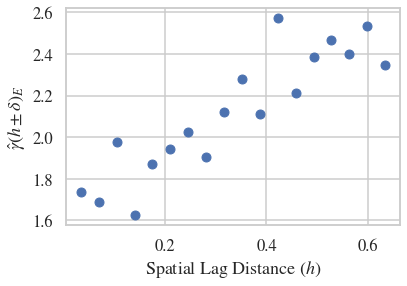

In [13]:
plt.plot(bins[1:-1],variogram_e[1::],'o')

plt.xlabel("Spatial Lag Distance ($h$)")
plt.ylabel("$\hat{\gamma}(h \pm \delta)_E$")

# plt.xlim(-0.01,.5)
# plt.ylim(500,1000)

plt.savefig("Euclid_Variogram.svg")

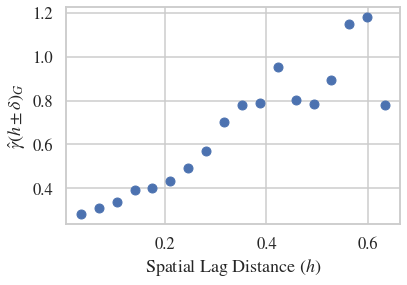

In [14]:
plt.plot(bins[1:-1],variogram_g[1::],'o')

plt.xlabel("Spatial Lag Distance ($h$)")
plt.ylabel("$\hat{\gamma}(h \pm \delta)_G$")

# plt.xlim(-0.01,.5)
# plt.ylim(.2,.65)
plt.savefig("Geo_Variogram.svg")